In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow
from tensorflow.keras import models, layers, utils, backend as K

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Conv1D, MaxPooling1D, GRU, Softmax
from keras.utils import np_utils

In [2]:
#Evaluation metrices that has to be used (objectives of project): accuracy, Average F1-score 
# ToDO: and Mean Average Precision (code provided on moodle) - needs to be added

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#taken from moodle
def computeMeanAveragePrecision(labels,softmaxEstimations):

    nbExamples , nbClasses = softmaxEstimations.shape

    averagePrecisions = np.zeros((nbClasses),dtype=np.float32)

    # For all classes
    for classIdx in range(nbClasses):

        # Sort the softmaxEstimations by decreasing order, and keep the order consistent with the labels
        permutation = list(reversed(np.argsort(softmaxEstimations[:,classIdx])))
        labelArray = np.asarray(labels)
        labelsTmp = list(labelArray[permutation])

        # Convert the labels to binary (1-vs-all)
        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == classIdx:
                labelsTmp[idx] = 1
            else:
                labelsTmp[idx] = 0

        # Compute the averaged sum of precisions by descending order
        nbPrecisionComputations = 0
        averagePrecisionSum = 0

        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == 1:
                averagePrecisionSum += np.sum(labelsTmp[:idx+1])/float(idx+1)
                nbPrecisionComputations += 1

        if nbPrecisionComputations == 0:
             averagePrecisions[classIdx] = 0
        else:
            averagePrecisions[classIdx] = averagePrecisionSum/float(nbPrecisionComputations)

    # Return global MAP and class MAPs
    return np.mean(averagePrecisions), averagePrecisions



In [3]:
#labels
#LABELS = ['Standing',
#          'Sitting',
#          'Lying',
#          'Squatting',
#          'Walking',
#          'Bending']

# dictionary of labels
labeldict = {
0 : "Bring",
1 : "Clean Floor",
2 : "Clean Surface",
4 : "Close Door",
5 : "Close Drawer",
6 : "Close Lid By Rotate",
7 : "Close Other Lid",
8 : "Close Small Box",
9 : "Close Tap Water",
10 : "Drink",
11 : "Dry Off Hands",
12 : "Dry Off Hands By Shake",
13 : "Eat Small",
14 : "Gargle",
15 : "Getting Up",
16 : "Hang",
17 : "Lying Down",
18 : "Open Bag",
19 : "Open Big Box",
20 : "Open Door",
21 : "Open Drawer",
22 : "Open Lid By Rotate",
23 : "Open Other Lid",
24 : "Open Small Box",
25 : "Open Tap Water",
26 : "Plug In",
27 : "Press by Grasp",
28 : "Press From Top",
29 : "Press Switch",
30 : "Put From Bottle",
31 : "Put From Tap Water",
32 : "Put High Position",
33 : "Put On Floor",
34 : "Read",
35 : "Rotate",
36 : "Rub Hands",
37 : "Scoop And Put",
38 : "Sitting Down",
39 : "Squatting Down",
40 : "Standing Up",
41 : "Stand Up From Squatting",
42 : "Take From Floor",
43 : "Take From High Position",
44 : "Take Off Jacket",
45 : "Take Out",
46 : "Talk By Telephone",
47 : "Throw Out",
48 : "Throw Out Water",
49 : "Touch Smartphone Screen",
50 : "Type",
51 : "Unhang",
52 : "Unplug",
53 : "Wear Jacket",
54 : "Write"
}
print('done')

done


In [4]:
# load data
# training
train_acc = np.load('training/trainAccelerometer.npy')
train_gra = np.load('training/trainGravity.npy')
train_gyr = np.load('training/trainGyroscope.npy')
train_lin = np.load('training/trainLinearAcceleration.npy')

train_mag = np.load('training/trainMagnetometer800.npy')

trainJins_acc = np.load('training/trainJinsAccelerometer800.npy')
trainJins_gyr = np.load('training/trainJinsGyroscope800.npy')

trainMS_acc = np.load('training/trainMSAccelerometer800.npy')
trainMS_gyr = np.load('training/trainMSGyroscope800.npy')

train_label = np.load('training/trainLabels.npy')
print('loading complete')

loading complete


In [5]:
# load data
# testing
test_acc = np.load('testing/testAccelerometer.npy')
test_gra = np.load('testing/testGravity.npy')
test_gyr = np.load('testing/testGyroscope.npy')
test_mag = np.load('testing/testMagnetometer800.npy')
test_lin = np.load('testing/testLinearAcceleration.npy')

testJins_acc = np.load('testing/testJinsAccelerometer800.npy')
testJins_gyr = np.load('testing/testJinsGyroscope800.npy')

testMS_acc = np.load('testing/testMSAccelerometer800.npy')
testMS_gyr = np.load('testing/testMSGyroscope800.npy')

test_label = np.load('testing/testLabels.npy')
print('loading complete')

loading complete


In [6]:
# create input feature vector

# train vector:
train_data = [train_gyr, train_mag, train_lin, trainJins_acc, trainJins_gyr, trainMS_acc, trainMS_gyr]

train_features = np.append(train_acc, train_gra, axis=2)
for i in train_data:
    train_features = np.append(train_features, i, axis=2)

print('x: number of examples/executions \ny: number of samples per channel \nz: number of channels')
print('Train Features Shape: ' + str(train_features.shape))
print('Train Gyr Shape: ' + str(train_gyr.shape))

x: number of examples/executions 
y: number of samples per channel 
z: number of channels
Train Features Shape: (2284, 800, 27)
Train Gyr Shape: (2284, 800, 3)


In [7]:
# set input and output dimensions
num_time_periods, num_sensors = train_features.shape[1], train_features.shape[2] #800, 27
num_classes = 55

# keras are not able to process multi-dimensional input data - data needs to be flattened
#  from 800x27 to 21600 values
input_shape = (num_time_periods * num_sensors)
train_features = train_features.reshape(train_features.shape[0], input_shape)

print('train_features/X_train shape:', train_features.shape)
print('input_shape:', input_shape)

train_features/X_train shape: (2284, 21600)
input_shape: 21600


In [8]:
# numeric values can be misinterpreted by algorithms as having some sort of
# hierarchy/order in them. done with one-hot-encoding
# run only once!!!
# y_train_hot ist eine matrix, die die klassen spaltenweise beschreibt (Einheitsmatrix)
y_train_hot = np_utils.to_categorical(train_label, num_classes)
print('New y_train shape: ', y_train_hot.shape) # 55 classes -> 55 columns; 2280 rows
print(train_label.shape)
print(num_classes)

New y_train shape:  (2284, 55)
(2284,)
55


In [9]:
#training data rename
X_train = train_features
Y_train = train_label
print(X_train.shape)
print(Y_train.shape)

(2284, 21600)
(2284,)


In [10]:
TIME_PERIODS = 800
# creation of model
model_4 = Sequential()
model_4.add(Reshape((TIME_PERIODS, 27), input_shape=(input_shape,)))
model_4.add(Dropout(0.1))
model_4.add(MaxPooling1D(pool_size=3)) ##
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(MaxPooling1D(pool_size=3))
model_4.add(Dropout(0.25))
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(MaxPooling1D(pool_size=3))
model_4.add(Dropout(0.25))
model_4.add(Conv1D(100, 20, activation='relu'))
model_4.add(Flatten())
model_4.add(Dense(55, activation='softmax'))

model_4.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 800, 27)           0         
                                                                 
 dropout (Dropout)           (None, 800, 27)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 266, 27)          0         
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 247, 100)          54100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 82, 100)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)  

2022-05-18 14:52:04.363652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-18 14:52:04.363763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
# Compile the model
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.00001) #0.0001
model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', F1])

# Train the model on the train set
BATCH_SIZE = 32
EPOCHS = 1000

history=model_4.fit(X_train, y_train_hot, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                  validation_split=0.2, verbose=1)

Epoch 1/1000


2022-05-18 14:52:04.499510: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 1/58 [..............................] - ETA: 31s - loss: 61.6812 - accuracy: 0.0000e+00 - F1: 0.0000e+00

2022-05-18 14:52:04.876324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/58 [============================>.] - ETA: 0s - loss: 39.3250 - accuracy: 0.0170 - F1: 0.0166

2022-05-18 14:52:05.983948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 2s 20ms/step - loss: 39.3008 - accuracy: 0.0170 - F1: 0.0163 - val_loss: 13.0575 - val_accuracy: 0.0109 - val_F1: 0.0000e+00
Epoch 2/1000
58/58 [==============================] - 1s 17ms/step - loss: 23.2337 - accuracy: 0.0213 - F1: 0.0185 - val_loss: 8.6344 - val_accuracy: 0.0219 - val_F1: 0.0059
Epoch 3/1000
58/58 [==============================] - 1s 16ms/step - loss: 16.6683 - accuracy: 0.0197 - F1: 0.0178 - val_loss: 6.8081 - val_accuracy: 0.0219 - val_F1: 0.0033
Epoch 4/1000
58/58 [==============================] - 1s 16ms/step - loss: 12.9264 - accuracy: 0.0235 - F1: 0.0145 - val_loss: 5.6872 - val_accuracy: 0.0306 - val_F1: 0.0071
Epoch 5/1000
58/58 [==============================] - 1s 16ms/step - loss: 10.1705 - accuracy: 0.0246 - F1: 0.0171 - val_loss: 4.9466 - val_accuracy: 0.0284 - val_F1: 0.0037
Epoch 6/1000
58/58 [==============================] - 1s 15ms/step - loss: 8.0036 - accuracy: 0.0203 - F1: 0.0113 - val_loss: 4.5620 - val

Epoch 48/1000
58/58 [==============================] - 1s 16ms/step - loss: 3.9723 - accuracy: 0.0367 - F1: 0.0154 - val_loss: 3.9595 - val_accuracy: 0.0350 - val_F1: 0.0162
Epoch 49/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.9662 - accuracy: 0.0323 - F1: 0.0114 - val_loss: 3.9623 - val_accuracy: 0.0350 - val_F1: 0.0162
Epoch 50/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.9495 - accuracy: 0.0416 - F1: 0.0156 - val_loss: 3.9586 - val_accuracy: 0.0350 - val_F1: 0.0162
Epoch 51/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.9501 - accuracy: 0.0421 - F1: 0.0227 - val_loss: 3.9570 - val_accuracy: 0.0372 - val_F1: 0.0162
Epoch 52/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.9571 - accuracy: 0.0345 - F1: 0.0195 - val_loss: 3.9557 - val_accuracy: 0.0394 - val_F1: 0.0162
Epoch 53/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.9579 - accuracy: 0.0367 - F1: 0.0196 - val_loss: 3.9

58/58 [==============================] - 1s 15ms/step - loss: 3.8336 - accuracy: 0.0624 - F1: 0.0410 - val_loss: 3.9135 - val_accuracy: 0.0372 - val_F1: 0.0280
Epoch 96/1000
58/58 [==============================] - 1s 16ms/step - loss: 3.8211 - accuracy: 0.0657 - F1: 0.0401 - val_loss: 3.9113 - val_accuracy: 0.0350 - val_F1: 0.0280
Epoch 97/1000
58/58 [==============================] - 1s 16ms/step - loss: 3.8185 - accuracy: 0.0744 - F1: 0.0472 - val_loss: 3.9140 - val_accuracy: 0.0350 - val_F1: 0.0280
Epoch 98/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.8131 - accuracy: 0.0640 - F1: 0.0526 - val_loss: 3.9082 - val_accuracy: 0.0350 - val_F1: 0.0280
Epoch 99/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.8123 - accuracy: 0.0706 - F1: 0.0458 - val_loss: 3.9074 - val_accuracy: 0.0416 - val_F1: 0.0280
Epoch 100/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.8192 - accuracy: 0.0722 - F1: 0.0497 - val_loss: 3.9096 - val_acc

Epoch 142/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.5436 - accuracy: 0.1330 - F1: 0.1119 - val_loss: 3.7414 - val_accuracy: 0.0656 - val_F1: 0.0516
Epoch 143/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.5295 - accuracy: 0.1253 - F1: 0.1073 - val_loss: 3.7258 - val_accuracy: 0.0766 - val_F1: 0.0516
Epoch 144/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.5443 - accuracy: 0.1248 - F1: 0.1189 - val_loss: 3.7128 - val_accuracy: 0.0788 - val_F1: 0.0517
Epoch 145/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.5299 - accuracy: 0.1363 - F1: 0.1173 - val_loss: 3.7270 - val_accuracy: 0.0722 - val_F1: 0.0477
Epoch 146/1000
58/58 [==============================] - 1s 16ms/step - loss: 3.5155 - accuracy: 0.1232 - F1: 0.1200 - val_loss: 3.7175 - val_accuracy: 0.0722 - val_F1: 0.0436
Epoch 147/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.5252 - accuracy: 0.1314 - F1: 0.1135 - val_los

Epoch 189/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.0835 - accuracy: 0.2365 - F1: 0.2332 - val_loss: 3.4007 - val_accuracy: 0.1641 - val_F1: 0.1167
Epoch 190/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.0878 - accuracy: 0.2310 - F1: 0.2278 - val_loss: 3.4001 - val_accuracy: 0.1597 - val_F1: 0.1093
Epoch 191/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.0863 - accuracy: 0.2326 - F1: 0.2326 - val_loss: 3.3985 - val_accuracy: 0.1554 - val_F1: 0.1061
Epoch 192/1000
58/58 [==============================] - 1s 16ms/step - loss: 3.0866 - accuracy: 0.2332 - F1: 0.2416 - val_loss: 3.3887 - val_accuracy: 0.1619 - val_F1: 0.1165
Epoch 193/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.0781 - accuracy: 0.2452 - F1: 0.2342 - val_loss: 3.3906 - val_accuracy: 0.1575 - val_F1: 0.1089
Epoch 194/1000
58/58 [==============================] - 1s 15ms/step - loss: 3.0601 - accuracy: 0.2337 - F1: 0.2358 - val_los

Epoch 236/1000
58/58 [==============================] - 1s 16ms/step - loss: 2.6088 - accuracy: 0.3350 - F1: 0.3340 - val_loss: 3.1011 - val_accuracy: 0.2232 - val_F1: 0.1836
Epoch 237/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.6063 - accuracy: 0.3350 - F1: 0.3522 - val_loss: 3.1007 - val_accuracy: 0.2123 - val_F1: 0.1707
Epoch 238/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.5828 - accuracy: 0.3421 - F1: 0.3527 - val_loss: 3.0803 - val_accuracy: 0.2232 - val_F1: 0.1829
Epoch 239/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.6086 - accuracy: 0.3273 - F1: 0.3466 - val_loss: 3.0874 - val_accuracy: 0.2188 - val_F1: 0.1768
Epoch 240/1000
58/58 [==============================] - 1s 16ms/step - loss: 2.5863 - accuracy: 0.3361 - F1: 0.3550 - val_loss: 3.0785 - val_accuracy: 0.2210 - val_F1: 0.1832
Epoch 241/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.5862 - accuracy: 0.3487 - F1: 0.3651 - val_los

Epoch 283/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.1655 - accuracy: 0.4417 - F1: 0.4663 - val_loss: 2.8943 - val_accuracy: 0.2779 - val_F1: 0.2736
Epoch 284/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.1835 - accuracy: 0.4406 - F1: 0.4701 - val_loss: 2.8863 - val_accuracy: 0.2823 - val_F1: 0.2671
Epoch 285/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.1858 - accuracy: 0.4340 - F1: 0.4744 - val_loss: 2.8794 - val_accuracy: 0.2779 - val_F1: 0.2743
Epoch 286/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.1769 - accuracy: 0.4406 - F1: 0.4670 - val_loss: 2.8847 - val_accuracy: 0.2823 - val_F1: 0.2691
Epoch 287/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.1311 - accuracy: 0.4472 - F1: 0.4833 - val_loss: 2.8921 - val_accuracy: 0.2735 - val_F1: 0.2784
Epoch 288/1000
58/58 [==============================] - 1s 15ms/step - loss: 2.1494 - accuracy: 0.4406 - F1: 0.4816 - val_los

Epoch 330/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.7704 - accuracy: 0.5304 - F1: 0.5682 - val_loss: 2.7570 - val_accuracy: 0.3107 - val_F1: 0.3379
Epoch 331/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.7444 - accuracy: 0.5271 - F1: 0.5726 - val_loss: 2.7304 - val_accuracy: 0.3282 - val_F1: 0.3541
Epoch 332/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.7740 - accuracy: 0.5205 - F1: 0.5702 - val_loss: 2.7148 - val_accuracy: 0.3304 - val_F1: 0.3442
Epoch 333/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.7694 - accuracy: 0.5156 - F1: 0.5677 - val_loss: 2.7121 - val_accuracy: 0.3348 - val_F1: 0.3581
Epoch 334/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.7174 - accuracy: 0.5413 - F1: 0.5831 - val_loss: 2.7176 - val_accuracy: 0.3304 - val_F1: 0.3620
Epoch 335/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.7258 - accuracy: 0.5320 - F1: 0.5849 - val_los

Epoch 377/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.3673 - accuracy: 0.6212 - F1: 0.6676 - val_loss: 2.6119 - val_accuracy: 0.3786 - val_F1: 0.3874
Epoch 378/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.3415 - accuracy: 0.6223 - F1: 0.6536 - val_loss: 2.6198 - val_accuracy: 0.3786 - val_F1: 0.3935
Epoch 379/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.3396 - accuracy: 0.6360 - F1: 0.6710 - val_loss: 2.6343 - val_accuracy: 0.3786 - val_F1: 0.3863
Epoch 380/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.3415 - accuracy: 0.6415 - F1: 0.6705 - val_loss: 2.6211 - val_accuracy: 0.3807 - val_F1: 0.3940
Epoch 381/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.3201 - accuracy: 0.6223 - F1: 0.6649 - val_loss: 2.6099 - val_accuracy: 0.3720 - val_F1: 0.3973
Epoch 382/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.3378 - accuracy: 0.6333 - F1: 0.6643 - val_los

Epoch 424/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.0151 - accuracy: 0.7165 - F1: 0.7381 - val_loss: 2.5630 - val_accuracy: 0.4158 - val_F1: 0.4218
Epoch 425/1000
58/58 [==============================] - 1s 16ms/step - loss: 1.0202 - accuracy: 0.7105 - F1: 0.7268 - val_loss: 2.5180 - val_accuracy: 0.4223 - val_F1: 0.4259
Epoch 426/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.0361 - accuracy: 0.7115 - F1: 0.7296 - val_loss: 2.5032 - val_accuracy: 0.4223 - val_F1: 0.4306
Epoch 427/1000
58/58 [==============================] - 1s 15ms/step - loss: 1.0143 - accuracy: 0.7066 - F1: 0.7287 - val_loss: 2.5225 - val_accuracy: 0.4289 - val_F1: 0.4291
Epoch 428/1000
58/58 [==============================] - 1s 16ms/step - loss: 0.9695 - accuracy: 0.7198 - F1: 0.7520 - val_loss: 2.5388 - val_accuracy: 0.4223 - val_F1: 0.4208
Epoch 429/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.9864 - accuracy: 0.7219 - F1: 0.7518 - val_los

Epoch 471/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.6738 - accuracy: 0.8155 - F1: 0.8151 - val_loss: 2.4923 - val_accuracy: 0.4748 - val_F1: 0.4645
Epoch 472/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.7007 - accuracy: 0.7969 - F1: 0.8201 - val_loss: 2.4969 - val_accuracy: 0.4683 - val_F1: 0.4691
Epoch 473/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.6990 - accuracy: 0.8051 - F1: 0.8190 - val_loss: 2.4801 - val_accuracy: 0.4639 - val_F1: 0.4612
Epoch 474/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.6613 - accuracy: 0.8155 - F1: 0.8271 - val_loss: 2.4984 - val_accuracy: 0.4683 - val_F1: 0.4595
Epoch 475/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.6730 - accuracy: 0.8084 - F1: 0.8232 - val_loss: 2.5179 - val_accuracy: 0.4508 - val_F1: 0.4547
Epoch 476/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.6790 - accuracy: 0.8084 - F1: 0.8157 - val_los

Epoch 518/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.4501 - accuracy: 0.8790 - F1: 0.8762 - val_loss: 2.5323 - val_accuracy: 0.4748 - val_F1: 0.5098
Epoch 519/1000
58/58 [==============================] - 1s 16ms/step - loss: 0.4441 - accuracy: 0.8763 - F1: 0.8819 - val_loss: 2.5508 - val_accuracy: 0.4770 - val_F1: 0.4945
Epoch 520/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.4831 - accuracy: 0.8593 - F1: 0.8631 - val_loss: 2.5456 - val_accuracy: 0.4836 - val_F1: 0.5049
Epoch 521/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.4672 - accuracy: 0.8801 - F1: 0.8766 - val_loss: 2.6076 - val_accuracy: 0.4814 - val_F1: 0.4959
Epoch 522/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.4573 - accuracy: 0.8763 - F1: 0.8785 - val_loss: 2.5469 - val_accuracy: 0.4858 - val_F1: 0.4906
Epoch 523/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.4383 - accuracy: 0.8741 - F1: 0.8807 - val_los

Epoch 565/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.3125 - accuracy: 0.9195 - F1: 0.9194 - val_loss: 2.6225 - val_accuracy: 0.4989 - val_F1: 0.5223
Epoch 566/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.3308 - accuracy: 0.9080 - F1: 0.9121 - val_loss: 2.6071 - val_accuracy: 0.4836 - val_F1: 0.5104
Epoch 567/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.3223 - accuracy: 0.9168 - F1: 0.9064 - val_loss: 2.6327 - val_accuracy: 0.4902 - val_F1: 0.5167
Epoch 568/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.3041 - accuracy: 0.9141 - F1: 0.9161 - val_loss: 2.6600 - val_accuracy: 0.4923 - val_F1: 0.5151
Epoch 569/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.3051 - accuracy: 0.9168 - F1: 0.9153 - val_loss: 2.6359 - val_accuracy: 0.4989 - val_F1: 0.5170
Epoch 570/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.2969 - accuracy: 0.9168 - F1: 0.9194 - val_los

Epoch 612/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.2213 - accuracy: 0.9464 - F1: 0.9471 - val_loss: 2.7254 - val_accuracy: 0.5142 - val_F1: 0.5428
Epoch 613/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.2035 - accuracy: 0.9464 - F1: 0.9438 - val_loss: 2.6860 - val_accuracy: 0.5295 - val_F1: 0.5393
Epoch 614/1000
58/58 [==============================] - 1s 16ms/step - loss: 0.2132 - accuracy: 0.9425 - F1: 0.9471 - val_loss: 2.7574 - val_accuracy: 0.5142 - val_F1: 0.5278
Epoch 615/1000
58/58 [==============================] - 1s 16ms/step - loss: 0.2116 - accuracy: 0.9447 - F1: 0.9432 - val_loss: 2.7466 - val_accuracy: 0.5142 - val_F1: 0.5235
Epoch 616/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.2063 - accuracy: 0.9475 - F1: 0.9373 - val_loss: 2.7094 - val_accuracy: 0.5208 - val_F1: 0.5333
Epoch 617/1000
58/58 [==============================] - 1s 16ms/step - loss: 0.2155 - accuracy: 0.9464 - F1: 0.9430 - val_los

Epoch 659/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.1408 - accuracy: 0.9677 - F1: 0.9610 - val_loss: 2.8819 - val_accuracy: 0.5077 - val_F1: 0.5306
Epoch 660/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.1360 - accuracy: 0.9639 - F1: 0.9652 - val_loss: 2.9560 - val_accuracy: 0.4989 - val_F1: 0.5246
Epoch 661/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.1368 - accuracy: 0.9644 - F1: 0.9634 - val_loss: 2.8419 - val_accuracy: 0.5055 - val_F1: 0.5365
Epoch 662/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.1380 - accuracy: 0.9617 - F1: 0.9666 - val_loss: 2.8830 - val_accuracy: 0.5098 - val_F1: 0.5399
Epoch 663/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.1266 - accuracy: 0.9732 - F1: 0.9712 - val_loss: 2.9100 - val_accuracy: 0.5164 - val_F1: 0.5421
Epoch 664/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.1326 - accuracy: 0.9655 - F1: 0.9659 - val_los

Epoch 706/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0907 - accuracy: 0.9787 - F1: 0.9805 - val_loss: 3.0734 - val_accuracy: 0.5274 - val_F1: 0.5372
Epoch 707/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0910 - accuracy: 0.9748 - F1: 0.9749 - val_loss: 2.9616 - val_accuracy: 0.5361 - val_F1: 0.5561
Epoch 708/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0890 - accuracy: 0.9765 - F1: 0.9736 - val_loss: 3.0086 - val_accuracy: 0.5339 - val_F1: 0.5454
Epoch 709/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0912 - accuracy: 0.9792 - F1: 0.9766 - val_loss: 3.1794 - val_accuracy: 0.5077 - val_F1: 0.5193
Epoch 710/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0905 - accuracy: 0.9776 - F1: 0.9787 - val_loss: 3.0539 - val_accuracy: 0.5295 - val_F1: 0.5441
Epoch 711/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0931 - accuracy: 0.9759 - F1: 0.9700 - val_los

Epoch 753/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0519 - accuracy: 0.9863 - F1: 0.9878 - val_loss: 3.1926 - val_accuracy: 0.5514 - val_F1: 0.5566
Epoch 754/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0529 - accuracy: 0.9901 - F1: 0.9871 - val_loss: 3.2842 - val_accuracy: 0.5339 - val_F1: 0.5439
Epoch 755/1000
58/58 [==============================] - 1s 16ms/step - loss: 0.0440 - accuracy: 0.9945 - F1: 0.9927 - val_loss: 3.2534 - val_accuracy: 0.5405 - val_F1: 0.5520
Epoch 756/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0464 - accuracy: 0.9891 - F1: 0.9888 - val_loss: 3.2608 - val_accuracy: 0.5383 - val_F1: 0.5488
Epoch 757/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0436 - accuracy: 0.9929 - F1: 0.9921 - val_loss: 3.2286 - val_accuracy: 0.5449 - val_F1: 0.5606
Epoch 758/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0470 - accuracy: 0.9896 - F1: 0.9899 - val_los

Epoch 800/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0293 - accuracy: 0.9945 - F1: 0.9954 - val_loss: 3.3433 - val_accuracy: 0.5514 - val_F1: 0.5600
Epoch 801/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0332 - accuracy: 0.9934 - F1: 0.9935 - val_loss: 3.2806 - val_accuracy: 0.5558 - val_F1: 0.5662
Epoch 802/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0311 - accuracy: 0.9940 - F1: 0.9906 - val_loss: 3.3009 - val_accuracy: 0.5427 - val_F1: 0.5569
Epoch 803/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0294 - accuracy: 0.9967 - F1: 0.9962 - val_loss: 3.3448 - val_accuracy: 0.5449 - val_F1: 0.5562
Epoch 804/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0333 - accuracy: 0.9951 - F1: 0.9937 - val_loss: 3.3205 - val_accuracy: 0.5449 - val_F1: 0.5533
Epoch 805/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0326 - accuracy: 0.9918 - F1: 0.9872 - val_los

Epoch 847/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0200 - accuracy: 0.9989 - F1: 0.9981 - val_loss: 3.4933 - val_accuracy: 0.5624 - val_F1: 0.5797
Epoch 848/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0156 - accuracy: 0.9984 - F1: 0.9989 - val_loss: 3.5708 - val_accuracy: 0.5580 - val_F1: 0.5633
Epoch 849/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0169 - accuracy: 0.9989 - F1: 0.9978 - val_loss: 3.5310 - val_accuracy: 0.5667 - val_F1: 0.5663
Epoch 850/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0167 - accuracy: 0.9978 - F1: 0.9976 - val_loss: 3.5351 - val_accuracy: 0.5558 - val_F1: 0.5722
Epoch 851/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0179 - accuracy: 0.9973 - F1: 0.9976 - val_loss: 3.5071 - val_accuracy: 0.5624 - val_F1: 0.5764
Epoch 852/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0176 - accuracy: 0.9984 - F1: 0.9984 - val_los

Epoch 894/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0210 - accuracy: 0.9951 - F1: 0.9956 - val_loss: 3.6229 - val_accuracy: 0.5514 - val_F1: 0.5705
Epoch 895/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0141 - accuracy: 0.9984 - F1: 0.9981 - val_loss: 3.6478 - val_accuracy: 0.5514 - val_F1: 0.5596
Epoch 896/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0111 - accuracy: 0.9989 - F1: 0.9986 - val_loss: 3.5341 - val_accuracy: 0.5602 - val_F1: 0.5746
Epoch 897/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0113 - accuracy: 1.0000 - F1: 0.9997 - val_loss: 3.5763 - val_accuracy: 0.5536 - val_F1: 0.5716
Epoch 898/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0109 - accuracy: 0.9995 - F1: 0.9992 - val_loss: 3.5790 - val_accuracy: 0.5536 - val_F1: 0.5696
Epoch 899/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0109 - accuracy: 1.0000 - F1: 1.0000 - val_los

Epoch 941/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0111 - accuracy: 0.9984 - F1: 0.9981 - val_loss: 3.5108 - val_accuracy: 0.5821 - val_F1: 0.5949
Epoch 942/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0092 - accuracy: 0.9989 - F1: 0.9989 - val_loss: 3.6923 - val_accuracy: 0.5602 - val_F1: 0.5709
Epoch 943/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0095 - accuracy: 1.0000 - F1: 0.9997 - val_loss: 3.6952 - val_accuracy: 0.5536 - val_F1: 0.5650
Epoch 944/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0069 - accuracy: 1.0000 - F1: 1.0000 - val_loss: 3.6744 - val_accuracy: 0.5558 - val_F1: 0.5714
Epoch 945/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0069 - accuracy: 1.0000 - F1: 1.0000 - val_loss: 3.6504 - val_accuracy: 0.5624 - val_F1: 0.5731
Epoch 946/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0074 - accuracy: 0.9995 - F1: 0.9943 - val_los

Epoch 988/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0065 - accuracy: 1.0000 - F1: 0.9997 - val_loss: 3.7557 - val_accuracy: 0.5799 - val_F1: 0.5979
Epoch 989/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0059 - accuracy: 0.9995 - F1: 0.9995 - val_loss: 3.7979 - val_accuracy: 0.5799 - val_F1: 0.5959
Epoch 990/1000
58/58 [==============================] - 1s 16ms/step - loss: 0.0048 - accuracy: 1.0000 - F1: 0.9997 - val_loss: 3.7695 - val_accuracy: 0.5842 - val_F1: 0.5996
Epoch 991/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0064 - accuracy: 0.9984 - F1: 0.9984 - val_loss: 3.8026 - val_accuracy: 0.5799 - val_F1: 0.5964
Epoch 992/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0050 - accuracy: 1.0000 - F1: 1.0000 - val_loss: 3.7612 - val_accuracy: 0.5864 - val_F1: 0.5989
Epoch 993/1000
58/58 [==============================] - 1s 15ms/step - loss: 0.0044 - accuracy: 1.0000 - F1: 1.0000 - val_los

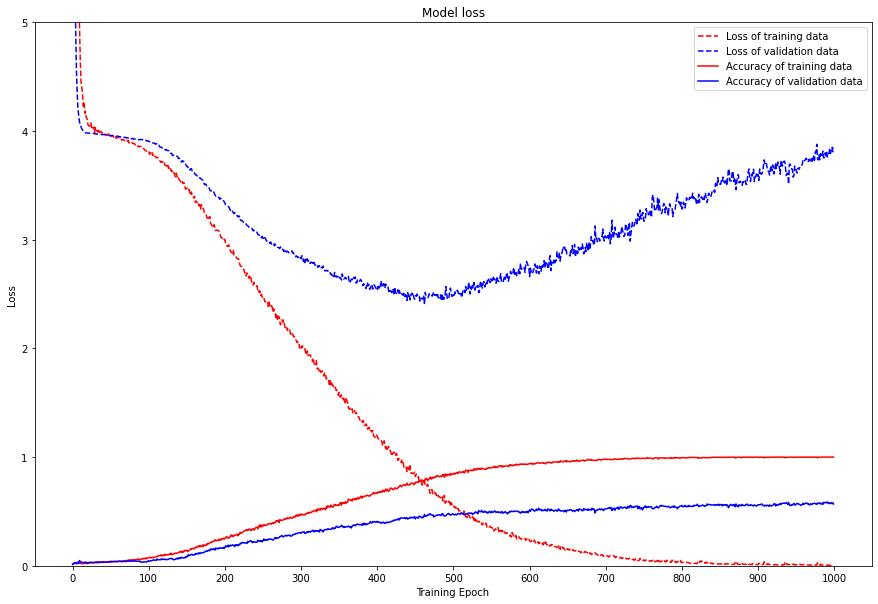

In [35]:
plt.figure(figsize=(15, 10))

plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')


plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.xticks(range(0, 1001, 100))
plt.yticks(range(0, 6))
plt.ylim(0,5)
plt.legend()
plt.show()

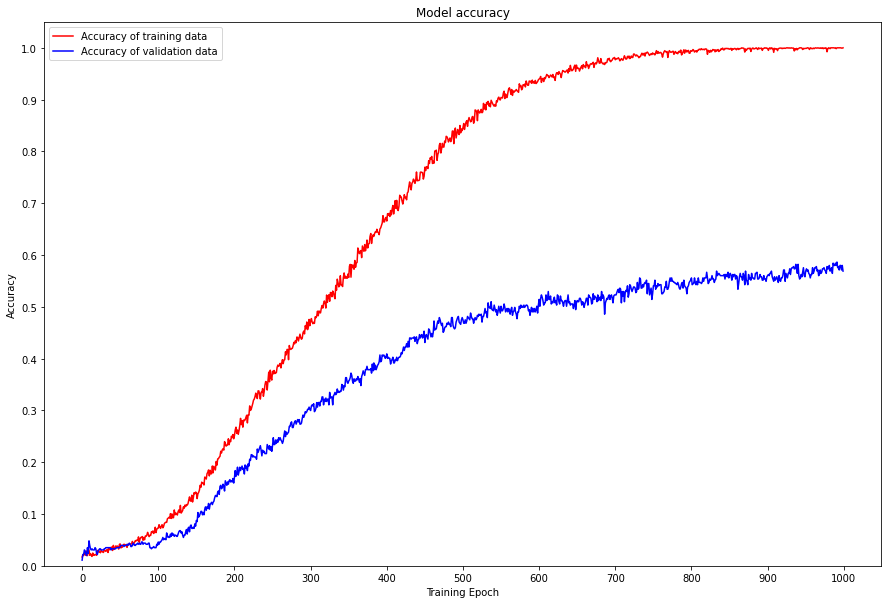

In [32]:
plt.figure(figsize=(15, 10))

plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.xticks(range(0, 1001, 100))
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.ylim(0)
plt.legend()
plt.show()

In [19]:
# Print confusion matrix for training data
y_pred_train = model_4.predict(train_features)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(train_label.shape, max_y_pred_train.shape, train_features.shape)
print(classification_report(train_label, max_y_pred_train))

(2284,) (2284,) (2284, 21600)
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        41
           1       0.92      0.86      0.89        42
           2       0.88      0.84      0.86        43
           3       0.86      0.90      0.88        42
           4       0.83      0.81      0.82        48
           5       0.75      0.90      0.82        42
           6       0.89      0.79      0.84        42
           7       0.76      0.85      0.80        46
           8       0.80      0.85      0.82        47
           9       1.00      0.70      0.82        20
          10       0.65      0.96      0.77        45
          11       0.94      0.83      0.88        41
          12       1.00      0.95      0.97        40
          13       0.89      0.97      0.93        40
          14       1.00      0.90      0.95        40
          15       0.93      0.98      0.95        42
          16       1.00      0.82      0.90        

In [13]:
model_4.save('model_4.x1000.00001')

2022-05-18 15:07:02.055966: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_4.x1000.00001/assets


I think the effect of increasing loss and accuracy is caused by a network that, at a given epoch, might be severely overfit on some classes but still learning on others.